In [1]:
import sys
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
from cogsci2017.learning.supervisor import Supervisor
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

iterations = 5000

environment = CogSci2017Environment(gui=False, audio=False)


config = dict(m_mins=environment.conf.m_mins,
             m_maxs=environment.conf.m_maxs,
             s_mins=environment.conf.s_mins,
             s_maxs=environment.conf.s_maxs)

agent = Supervisor(config, model_babbling="random", n_motor_babbling=1000, explo_noise=0.05)



human sounds ['euo', 'uie', 'ieu', 'uyi', 'oey', 'oiy']


Iteration 0


../cogsci2017/environment/diva/diva.py:169: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))


Iteration 500
best_vocal_errors [('euo', 0.95014146006114231), ('uie', 0.89886178805026551), ('ieu', 1.1548850508546127), ('uyi', 0.90482580084620978), ('oey', 0.76811506820525832), ('oiy', 0.873593761603495)]
Iteration 1000
Iteration 1500
best_vocal_errors [('euo', 0.5646991982294628), ('uie', 0.80447634913285571), ('ieu', 1.1445027485640569), ('uyi', 0.69535563131804379), ('oey', 0.76811506820525832), ('oiy', 0.79192393746239986)]
Iteration 2000
Iteration 2500
***********Agent says oiy
best_vocal_errors [('euo', 0.5646991982294628), ('uie', 0.61851208542996128), ('ieu', 0.89487071217977621), ('uyi', 0.56632245084015076), ('oey', 0.59940408737338524), ('oiy', 0.47788604978418514)]
Iteration 3000
***********Agent says oey
Iteration 3500
***********Agent says uyi
***********Agent says uyi
***********Agent says oey
best_vocal_errors [('euo', 0.5646991982294628), ('uie', 0.61851208542996128), ('ieu', 0.57220574483932962), ('uyi', 0.43248313471104211), ('oey', 0.48257728220833651), ('oiy',

(-9.25, -7.5)

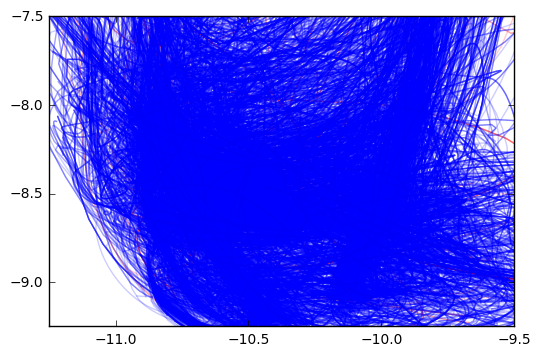

In [2]:
for i in range(iterations):
    if i % (iterations/10) == 0:
        print "Iteration", i
    context = environment.get_current_context()
    m = agent.produce(context)
    s = environment.update(m)
    agent.perceive(s)
    s_traj = environment.diva_traj
    if s_traj is not None:
        if i < 100:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
        else:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
            
plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

error oiy 0.639352616533


(-9.25, -7.5)

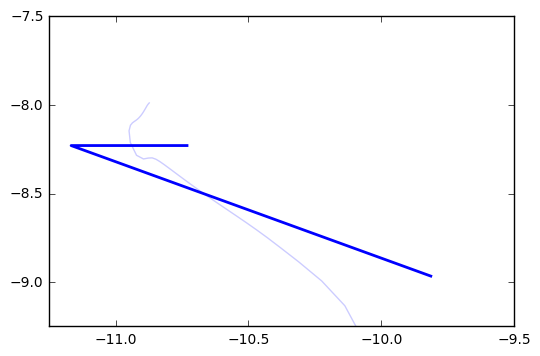

In [173]:
#for hs in human_sounds:
hs = "oiy"
agent.modules["mod13"].sm.sigma_expl = np.array([0.1]*28)
#print agent.modules["mod13"].sm.sigma_expl
m = agent.modules["mod13"].inverse(np.array(environment.human_sounds_traj_std[hs]), explore=True) 
#print m
s = environment.update([0.]*21 + list(m))
s_traj = environment.diva_traj
#print s_traj
error = np.linalg.norm(np.array(environment.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
print "error", hs, error


plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)    
plt.plot(- np.array(environment.human_sounds_traj[hs][5:]), -np.array(environment.human_sounds_traj[hs][:5]), lw=2)

plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

In [3]:

for i in range(100):
    context = environment.get_current_context()[:4]
    s_goal = [2. * np.random.random() - 1. for _ in range(10)]

    m = agent.modules["mod10"].inverse(np.array(context + s_goal), explore=True)
    m = [0.] * 21 + list(m)
    s = environment.update(m)
    if environment.produced_sound:
        print environment.produced_sound
    agent.perceive(s)

In [175]:
print agent.modules["mod10"].sm.model.imodel.fmodel.dataset.data

[[array([-0.75813264,  0.87603349, -0.16221033,  0.56014146, -0.48048549,
       -0.2163075 ,  0.92033399,  0.59825421,  0.71942913,  0.24596559,
        0.14066216,  0.09530328,  0.05748578, -0.54190869, -0.81152254,
       -0.92299676,  0.26258749,  0.9978456 , -0.60045915,  0.00992366,
        0.02796501,  0.68599286, -0.9424518 , -0.20790301, -0.27886597,
        0.66869553, -0.49040605,  0.0021973 ]), array([-0.49820761, -0.49213914, -0.05374332,  0.43450036,  0.23562271,
        0.35206051, -0.47715426,  0.44742999, -0.56242079, -0.59620023,
        0.03127188,  0.49251704, -0.15448996,  0.12773426,  0.55232413,
        0.88824382,  0.30034553, -0.07797654,  0.77913661, -0.30126625,
       -0.53200885, -0.97224958, -0.48640728, -0.04697224,  0.33067287,
        0.54647859, -0.06745527,  0.07877772]), array([-0.53116363, -0.43933376, -0.03921061,  0.36304456,  0.39419255,
        0.28517359, -0.5312298 ,  0.46118792, -0.4155638 , -0.45487002,
        0.06496953,  0.41128275, -0.02